# Use feature vectors as RGB images

Since the dimensionality reduction (to 3) on the feature vectors, they can be treated as images with 3 channels (RGB). They will be used for:

* Calculate their [SSIM](https://youtu.be/16s3Pi1InPU)
* Compare their histogram

In [1]:
# imports
import numpy as np
import pandas as pd
import torchvision
import matplotlib.pyplot as plt
import glob
import cv2
import os

from typing import Callable
from PIL import Image
from sklearn.decomposition import PCA
from skimage.metrics import structural_similarity
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline  

### Feature extraction

Layer 30 will be used, then performs pca for the dimensionality reduction

In [2]:
features = {}
layer = 29

model = torchvision.models.vgg16(pretrained=True)

# hook
def reg_hook(name: str) -> Callable:
    def hook(model, input, output):
        features[name] = output.detach()
    return hook

# register hook on level
model.features[layer].register_forward_hook(reg_hook('feats'))

# transform callable functoin for the images
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(224),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
    ),
])

# path for the folder that contains the images
path = "../data/preprocess/"

# function to open images and return them as a list
def open_images(path: str, case: str, tp: str) -> list:
    lst = []
    for filename in glob.glob(path + case + "/" + tp + "/*.JPG"):
        lst.append(Image.open(filename).convert("RGB"))
    return lst

def pca(image: np.ndarray, dimension: int = 8) -> np.ndarray:
    '''A tensor with H x W x C, we reshape it to an array of HW x C (pixels x dimension of data)'''
    N = image.shape[2] * image.shape[3] # HxW
    C = image.shape[1] # Dimensions: Kernels
    X = np.reshape(image, [N, C])
    feats = PCA(n_components=dimension).fit_transform(X)
    return np.reshape(feats, [image.shape[2], image.shape[3], feats.shape[1]])

def Average(lst):
    return sum(lst) / len(lst)

def extract_features(model: torchvision.models, transform: Callable, images: list) -> list:

    # function to normalize the vector
    def normalize(A: np.ndarray) -> np.ndarray:
        norm = np.linalg.norm(A)
        return A / norm

    embeddings = []
    
    # iterate through all images and save the features in the list
    for image in images:
        x = transform(image).unsqueeze(0).to("cpu")
        _ = model(x)

        embeddings.append(normalize(features["feats"].cpu().numpy()))
        
    return embeddings

In [3]:
def show_images(case: str, images: list, similarity: list):
    
    images = [NormalizeData(array) for array in images]

    # create figure
    fig = plt.figure(figsize=(10, 7))
    
    # setting values to rows and column variables
    rows = 1
    columns = 3
    
    # Adds a subplot at the 1st position
    fig.add_subplot(rows, columns, 1)
    
    # showing image
    plt.imshow(images[0])
    plt.axis('off')
    plt.title(f"{case}: wound")
    
    # Adds a subplot at the 2nd position
    fig.add_subplot(rows, columns, 2)
    
    # showing image
    plt.imshow(images[1])
    plt.axis('off')
    plt.title(f"similarity: {similarity[0]:.3f}")
    
    # Adds a subplot at the 3rd position
    fig.add_subplot(rows, columns, 3)
    
    # showing image
    plt.imshow(images[2])
    plt.axis('off')
    plt.title(f"similarity: {similarity[1]:.3f}")

### SSIM

The Structural Similarity Index (SSIM) is a perceptual metric that quantifies the image quality degradation that is caused by processing such as data compression or by losses in data transmission. This metric is basically a full reference that requires 2 images from the same shot, this means 2 graphically identical images to the human eye. The second image generally is compressed or has a different quality, which is the goal of this index. SSIM is usually used in the video industry, but has as well a strong application in photography. SIM actually measures the perceptual difference between two similar images. It cannot judge which of the two is better: that must be inferred from knowing which is the original one and which has been exposed to additional processing such as compression or filters.

# Histogram

Using opencv, calculates the histogram of the images using the function [cv2.calchist](https://pyimagesearch.com/2021/04/28/opencv-image-histograms-cv2-calchist/) using 8 bins.

Using [HISTCMP_CHISQR](https://pyimagesearch.com/2014/07/14/3-ways-compare-histograms-using-opencv-python/). Applies the Chi-Squared distance to the histograms. (closer to 0 is better)


C:\Users\giann\AppData\Local\Temp\ipykernel_17440\3331355580.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(10, 7))


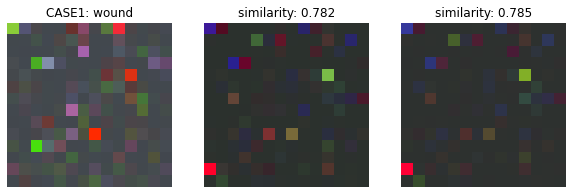

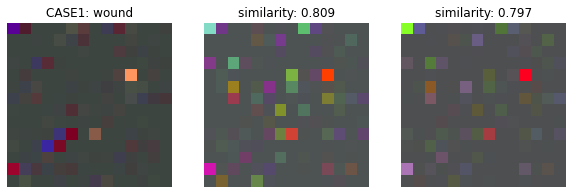

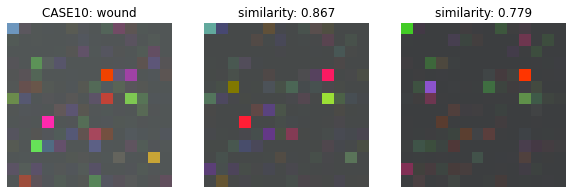

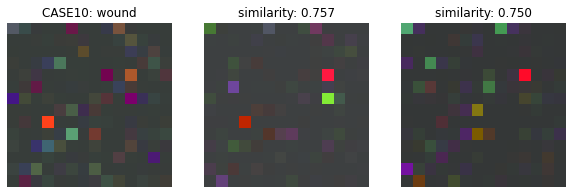

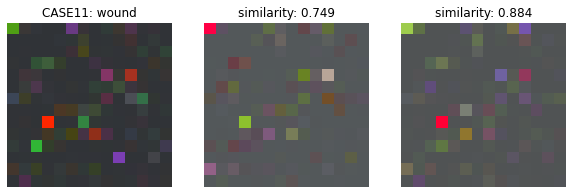

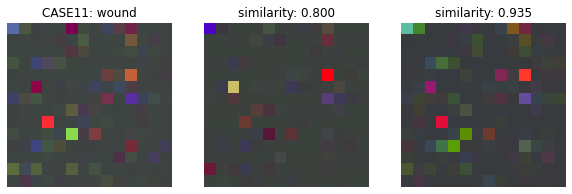

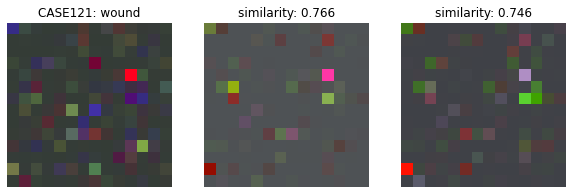

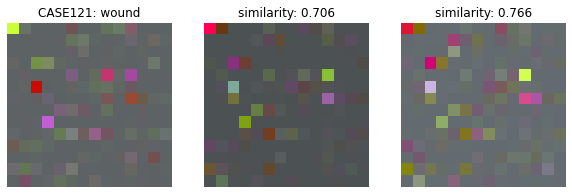

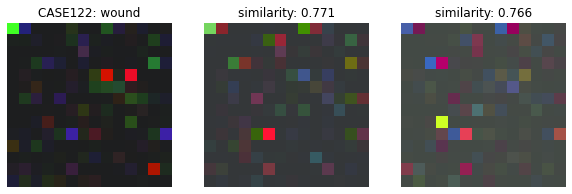

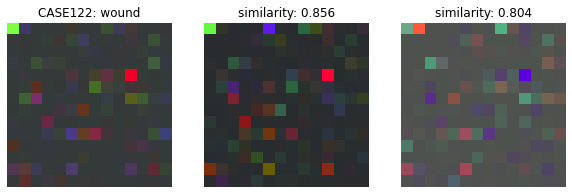

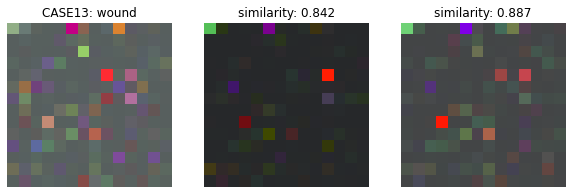

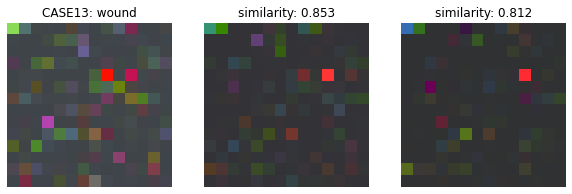

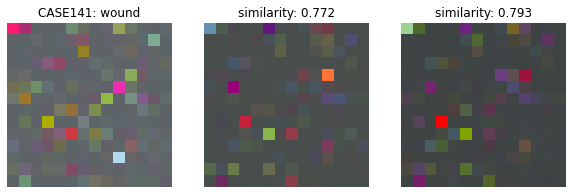

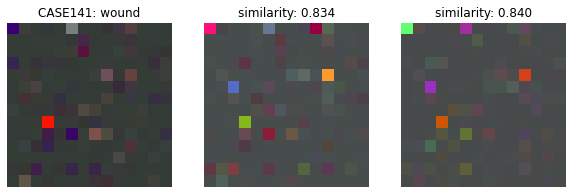

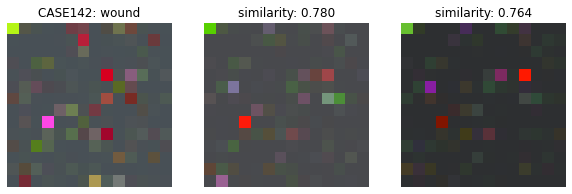

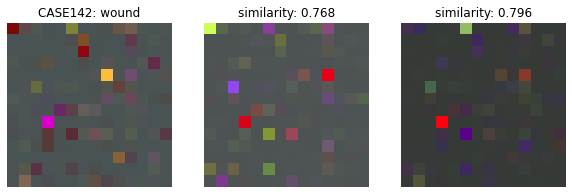

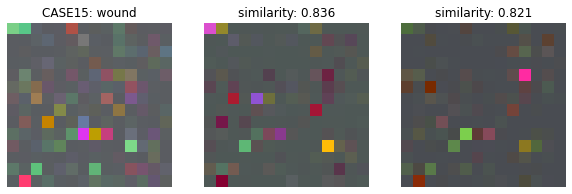

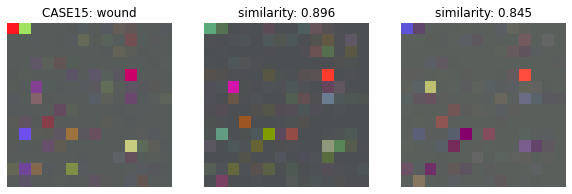

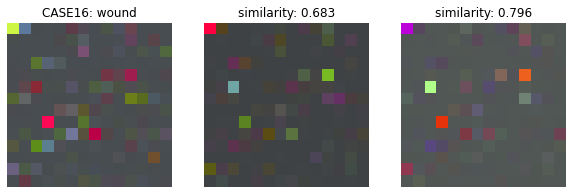

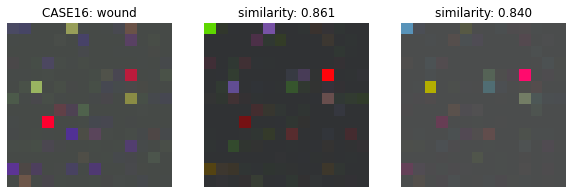

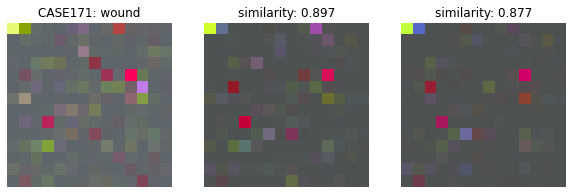

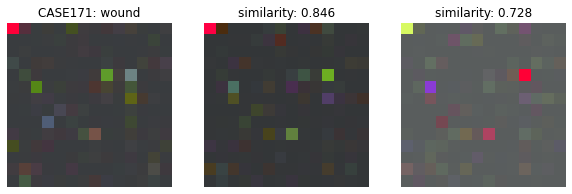

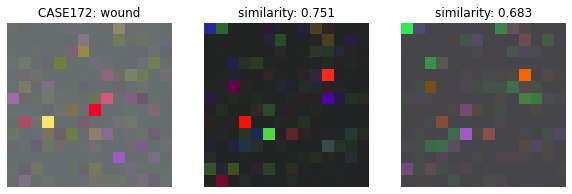

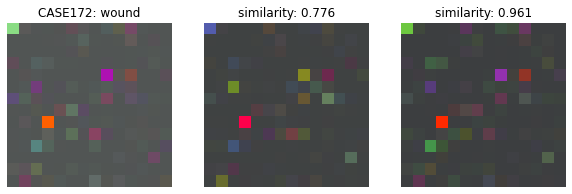

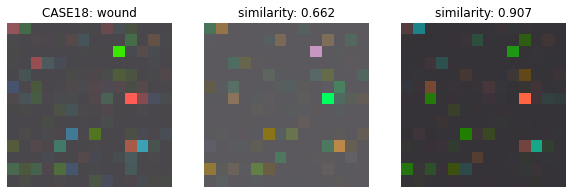

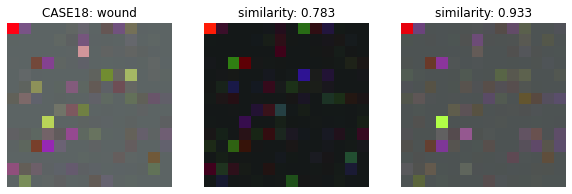

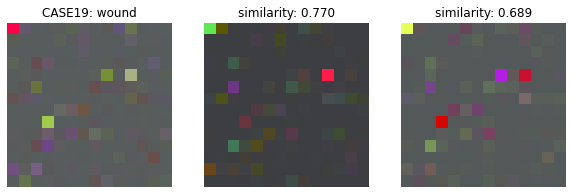

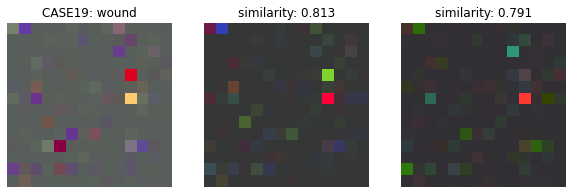

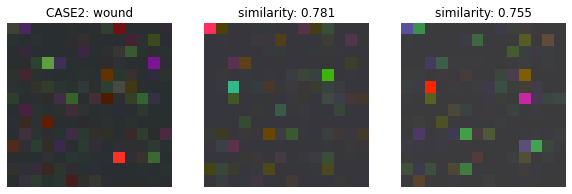

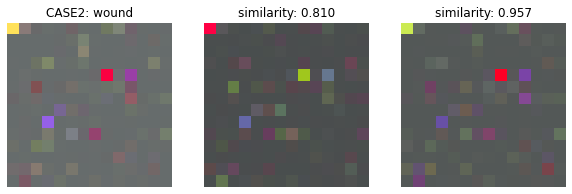

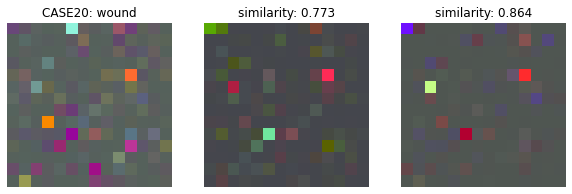

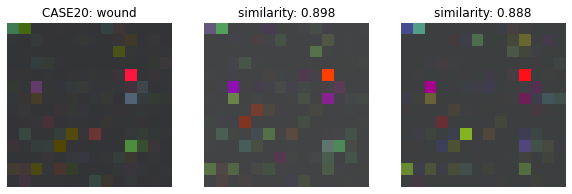

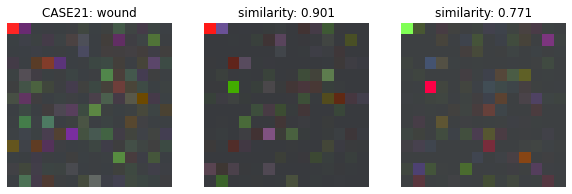

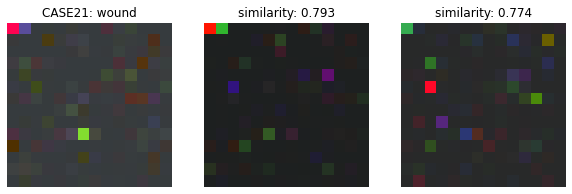

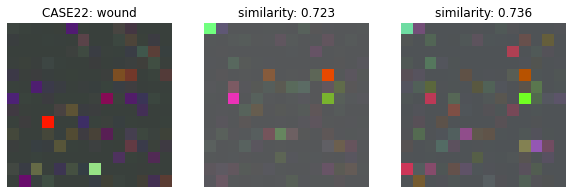

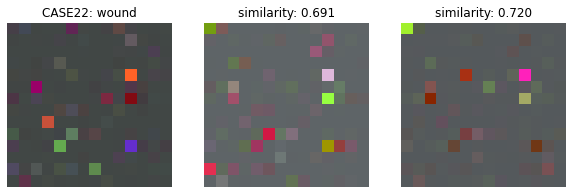

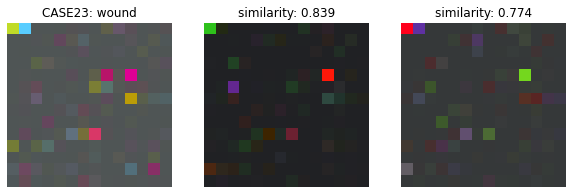

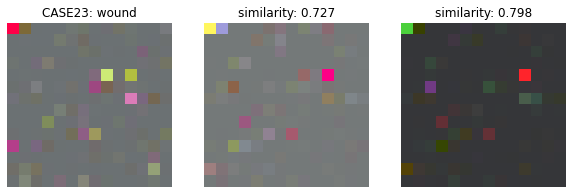

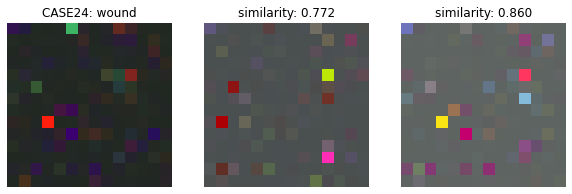

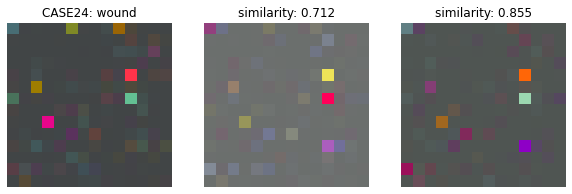

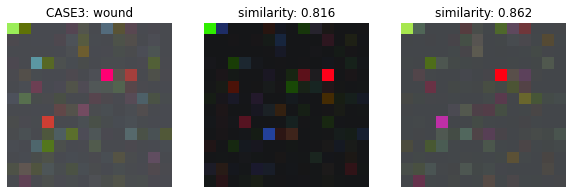

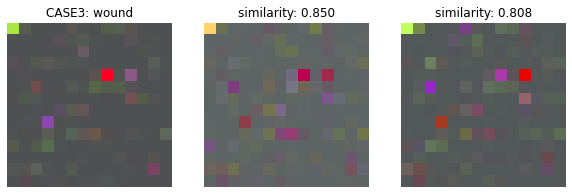

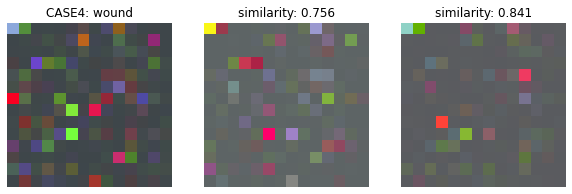

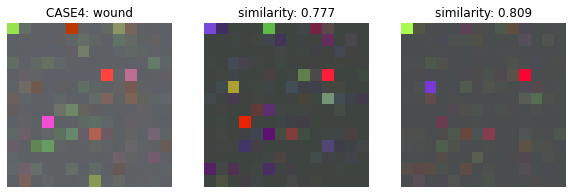

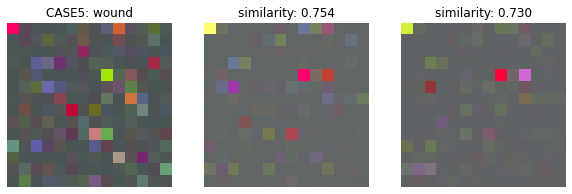

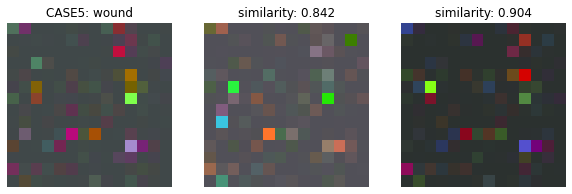

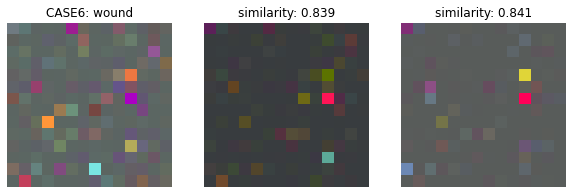

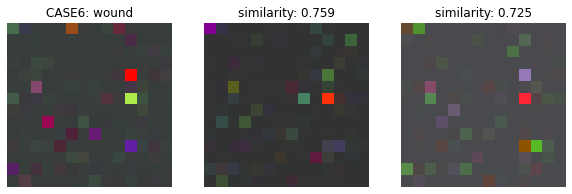

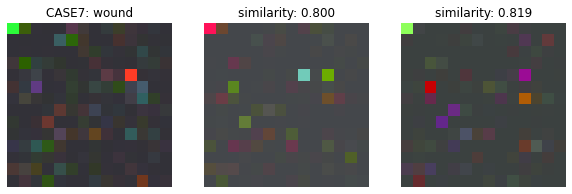

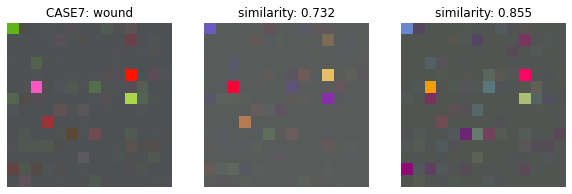

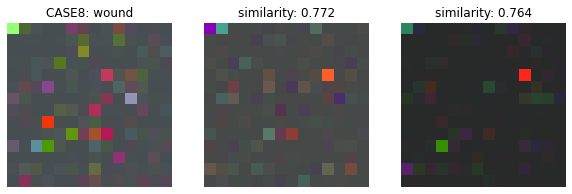

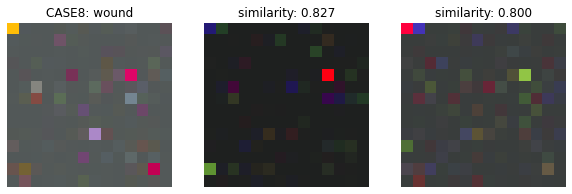

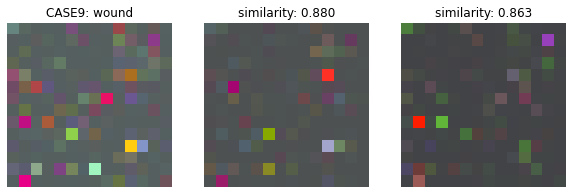

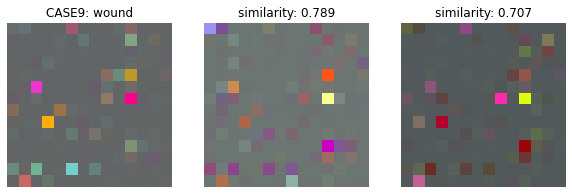

In [4]:
def calculate_ssim(lst: list) -> tuple:
    '''calculates the ssim of the list and returns the average value'''
    A, B, C = lst
    sim_ab, _ = structural_similarity(A, B, full=True, channel_axis=2)
    sim_ac, _ = structural_similarity(A, C, full=True, channel_axis=2)
    return (Average([sim_ab, sim_ac]), sim_ab, sim_ac)

def compare_hist(lst: list, method: Callable) -> float:
    '''Given a list of histograms, compare them with the desired method and return the average value'''
    A, B, C = lst
    histB = cv2.compareHist(A, B, method)
    histC = cv2.compareHist(A, C, method)
    return Average([histB, histC])

def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

    
cases = [f.path[19:] for f in os.scandir(path) if f.is_dir()]
results = []

for case in cases:
    # get the images of the cases
    images_before = open_images(path=path, case=case, tp='BEFORE')
    images_after = open_images(path=path, case=case, tp='AFTER')

    # get the embeddings
    before_embeddings = extract_features(model=model, transform=transform, images=images_before)
    after_embeddings = extract_features(model=model, transform=transform, images=images_after)

    # perform the pca
    bf = [pca(image=array, dimension=3) for array in before_embeddings]
    af = [pca(image=array, dimension=3) for array in after_embeddings]
    
    before_ssim, bab, bac = calculate_ssim(bf)
    after_ssim, aab, aac = calculate_ssim(af)
    
    bf_hist = []
    af_hist = []
    
    # calculate the histograms
    for i, array in enumerate(bf):
        bf_hist.append(cv2.calcHist(images=[bf[i]], channels=[0, 1, 2], mask=None, histSize=[16, 16, 16], ranges=[-1, 1, -1, 1, -1, 1]))
        af_hist.append(cv2.calcHist(images=[af[i]], channels=[0, 1, 2], mask=None, histSize=[16, 16, 16], ranges=[-1, 1, -1, 1, -1, 1]))
    
    histBe = compare_hist(lst=bf_hist, method=cv2.HISTCMP_CORREL)
    histAf = compare_hist(lst=af_hist, method=cv2.HISTCMP_CORREL)
    
    show_images(case, bf, [bab, bac])
    show_images(case, af, [aab, aac])
    
    results.append((case, round(before_ssim, 3), round(after_ssim, 3), round(histBe, 3), round(histAf, 3)))

In [5]:
## Create the dataframe
df = pd.DataFrame(results, columns=['Case', 'Before','After', 'Hist Before', 'Hist After'])
# generate csv with the results
df.to_csv(f'../csv/ssim_histogram/{layer}_vgg16_ssim_histogram.csv', index=False)

In [6]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [7]:
# bf_hist[0].shape = 96